In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
from pathlib import Path

DPI = 300
FONTSIZE = 20  # 42
sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)

In [2]:
gene_sign = "AP1_regulon_updated"
receiver="ipEMT"
DIR2LOAD = Path("/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/nichenet/concat_withWu2022/nichenet_microenvall_celltypes/intersect_cellphonedb/")

In [3]:
FIG2SAVE = DIR2LOAD.joinpath(f"figures/final/{gene_sign}_{receiver}/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
# table containing final ligand receptor interactions 
lr_df = pd.read_csv(DIR2LOAD.joinpath(f"{gene_sign}{receiver}_final_LR.csv"),
                    sep=",",
                    header=0,
                   )
lr_df.shape

(127, 3)

In [5]:
lr_df.head(3)

,from,to,potential
0,ANXA1,EGFR,0.903599
1,APOE,LDLR,1.266901
2,APOE,LRP1,0.895746


In [6]:
# create column interaction ligand-receptor
lr_df["interaction"] = lr_df["from"] + "_" + lr_df["to"]
lr_df

,from,to,potential,interaction
0,ANXA1,EGFR,0.903599,ANXA1_EGFR
1,APOE,LDLR,1.266901,APOE_LDLR
2,APOE,LRP1,0.895746,APOE_LRP1
3,APOE,SCARB1,0.850245,APOE_SCARB1
4,APOE,APP,0.818054,APOE_APP
...,...,...,...,...
122,VCAM1,MSN,0.751009,VCAM1_MSN
123,VEGFA,FLT1,1.647269,VEGFA_FLT1
124,VEGFB,FLT1,1.162845,VEGFB_FLT1
125,WNT5A,ROR2,0.954738,WNT5A_ROR2


### load raw scRNA-seq data 

In [7]:
# load raw scRNA-seq data 
SCRNA_FILE2LOAD = Path(f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/prepareInputRNA/Multiome_Che_Wu_CRC_LM_annotations_raw_no_cycling_TME.h5ad")
# ideally use new annotations with enivronment used in cellphonedb 
adata = sc.read_h5ad(SCRNA_FILE2LOAD)

In [8]:
adata.X[0:5, 0:5].todense()

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 2., 0.],
        [0., 0., 0., 1., 0.]], dtype=float32)

In [9]:
adata["CRC01_LM#AGGTTGCGTGAGCAAG-1-BCI-Nuclei", "A2M"].X.todense()

matrix([[2.]], dtype=float32)

In [10]:
adata["CRC01_LM#AGGTTGCGTGAGCAAG-1-BCI-Nuclei", "A1CF"].X.todense()

matrix([[1.]], dtype=float32)

In [11]:
### log normalise 
# keep raw
adata.layers["raw"] = adata.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
adata.layers["normalised"] = adata.X.copy()
sc.pp.log1p(adata)

adata.layers["log1p"] = adata.X.copy()

adata.raw = adata  # keep normalised log1p

In [12]:
adata.X[0:5, 0:5].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.66984034, 1.0674143 , 0.        ],
        [0.        , 0.        , 0.        , 1.6233416 , 0.        ]],
       dtype=float32)

In [13]:
# to check lognormalised and cpm to 10,000
import numpy as np
np.expm1(adata.X).sum(axis=1)

matrix([[10000.001],
        [ 9999.999],
        [10000.001],
        ...,
        [10000.001],
        [10000.   ],
        [ 9999.999]], dtype=float32)

In [14]:
adata.obs.Annotation_scVI_detailed.value_counts()

CD4 Th               10325
CD8 Tem               8683
Treg                  7655
CD8 Tex               7531
CD4 Th HSP            7246
CD8 Tem HSP           6178
CD4 Tn                4778
SPP1 Mac              4619
MAIT                  4463
TA1                   4116
CD8 Tem GZMB          3269
NK1                   3178
CD4 Tfh               3010
Neutrophil            2892
Hypoxia               2481
NK2                   2321
B                     2116
NLRP3 Mac             2075
C1QC Mac              2006
CD4 Th17              1937
Stem (NOTUM high)     1933
Colonocyte            1913
gdT                   1761
Plasma                1610
cDC2                  1543
Stem                  1400
NKT                   1380
Intermediate          1319
FCN1 Mono              999
pEMT                   998
UPR                    759
Kupffer                600
PLTP LYVE1 Mac         574
IL1B Mac               550
ipEMT                  469
ECM CAF                441
HSP Mono               387
H

### select sender cells and zscore that object 

In [15]:
senders = [
    "ECM CAF", "Myofibroblast", "Pericyte",
    "SPP1 Mac", "Neutrophil", "IL1B Mac", "NLRP3 Mac",]

adata_sender = adata[adata.obs.Annotation_scVI_detailed.isin(senders)].copy()

In [16]:
### z score 
adata_zscore_sender = adata_sender.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore_sender.layers['scaled'] = sc.pp.scale(adata_zscore_sender, copy=True).X
adata_zscore_sender.obs=adata_sender.obs

### select epithelial cancer states and zscore that object

In [17]:
# isolate epithelial only 
adata_epi = adata[adata.obs.Annotation_scVI == "Epithelial"].copy()
adata_epi.obs.Annotation_scVI_detailed.value_counts()

TA1                  4116
Hypoxia              2481
Stem (NOTUM high)    1933
Colonocyte           1913
Stem                 1400
Intermediate         1319
pEMT                  998
UPR                   759
ipEMT                 469
Goblet                323
TA2                   162
Enteroendocrine        71
Tuft                   65
Name: Annotation_scVI_detailed, dtype: int64

In [18]:
### z score 
adata_zscore_epi = adata_epi.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore_epi.layers['scaled'] = sc.pp.scale(adata_zscore_epi, copy=True).X
adata_zscore_epi.obs=adata_epi.obs

In [19]:
# define cancer states we want to plot
cancerstates2plot = [
                  "Stem",
                  "Stem (NOTUM high)",
                  "TA1",
                  "Intermediate", 
                  "Hypoxia",
                  "pEMT",
                  "ipEMT"]

In [20]:
# only select cancer states we want to plot
adata_zscore_epi = adata_zscore_epi[adata_zscore_epi.obs.Annotation_scVI_detailed.isin(cancerstates2plot)].copy()

### append mean zscore to ligand-receptor table

In [21]:
# create tmp tme adata that just contains ligands as genes (has duplicates because following order of lr)
adata_tme2ligand = adata_zscore_sender[:, lr_df["from"]].copy()
adata_tme2ligand.shape

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(10708, 127)

In [22]:
zscore_tme = pd.DataFrame(columns=adata_tme2ligand.obs['Annotation_scVI_detailed'].cat.categories, 
                          index=lr_df["interaction"]) 

zscore_tme.head(3)

,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac
interaction,,,,,,,
ANXA1_EGFR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOE_LDLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOE_LRP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# compute average z-score per cell type per gene
for celltype in adata_tme2ligand.obs.Annotation_scVI_detailed.cat.categories:
    zscore_tme.loc[:, celltype] = adata_tme2ligand[
        adata_tme2ligand.obs.Annotation_scVI_detailed.isin([celltype]), :].layers["scaled"].mean(axis=0).T
zscore_tme = zscore_tme.astype(float)

In [24]:
zscore_tme.head(5)

,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac
interaction,,,,,,,
ANXA1_EGFR,-0.606296,0.124196,-0.111946,0.399817,-0.794114,-0.790092,0.368269
APOE_LDLR,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684
APOE_LRP1,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684
APOE_SCARB1,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684
APOE_APP,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684


### do the same for the cancerr cell states 

In [25]:
# create tmp cancer state adata that just contains receptors as genes (has duplicates because following order of lr)
adata_epi2receptor = adata_zscore_epi[:, lr_df["to"]].copy()
adata_epi2receptor.shape

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(12716, 127)

In [26]:
zscore_epi = pd.DataFrame(columns=adata_epi2receptor.obs.Annotation_scVI_detailed.cat.categories,
                          index=lr_df["interaction"]
                         )
zscore_epi.head(5)

,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT
interaction,,,,,,,
ANXA1_EGFR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOE_LDLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOE_LRP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOE_SCARB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOE_APP,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
for celltype in adata_epi2receptor.obs.Annotation_scVI_detailed.cat.categories:
    zscore_epi.loc[:, celltype] = adata_epi2receptor[
        adata_epi2receptor.obs.Annotation_scVI_detailed.isin([celltype]), :].layers["scaled"].mean(axis=0).T
zscore_epi = zscore_epi.astype(float)
zscore_epi.head(5)

,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT
interaction,,,,,,,
ANXA1_EGFR,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559
APOE_LDLR,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806
APOE_LRP1,0.186824,-0.175956,-0.103401,-0.019446,0.014403,-0.091369,0.210210
APOE_SCARB1,0.182209,0.060964,-0.201821,0.016896,-0.001276,-0.006686,0.223609
APOE_APP,-0.043045,0.201691,0.039224,0.152743,-0.092768,0.087813,-0.131941


### to select: create another column where we compute difference mean zscore ipEMT vs other cancer states (except pEMT as it is similr to ipEMT) and we will use this to filter the receptors 

In [28]:
cancerstate2exclude = ["ipEMT", "pEMT"]

In [29]:
zscore_epi.loc[:, "cancer_state_means"]  = adata_epi2receptor[~adata_epi2receptor.obs.Annotation_scVI_detailed.isin(cancerstate2exclude), :].layers["scaled"].mean(axis=0).T

In [30]:
zscore_epi

,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means
interaction,,,,,,,,
ANXA1_EGFR,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643
APOE_LDLR,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422
APOE_LRP1,0.186824,-0.175956,-0.103401,-0.019446,0.014403,-0.091369,0.210210,0.009638
APOE_SCARB1,0.182209,0.060964,-0.201821,0.016896,-0.001276,-0.006686,0.223609,0.024654
APOE_APP,-0.043045,0.201691,0.039224,0.152743,-0.092768,0.087813,-0.131941,0.011339
...,...,...,...,...,...,...,...,...
VCAM1_MSN,-0.007943,0.356754,-0.086673,-0.030111,0.024500,0.164715,-0.010658,0.033090
VEGFA_FLT1,-0.018273,-0.028901,-0.080126,-0.001405,0.027534,0.813931,0.035865,-0.007558
VEGFB_FLT1,-0.018273,-0.028901,-0.080126,-0.001405,0.027534,0.813931,0.035865,-0.007558


### merge these two dataframes and then merge with ligand receptor dataframe

In [31]:
zscore_lr = zscore_tme.merge(right=zscore_epi,
                             how="inner",
                             left_index=True,
                             right_index=True
                            )

In [32]:
zscore_lr.head(3)

,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means
interaction,,,,,,,,,,,,,,,
ANXA1_EGFR,-0.606296,0.124196,-0.111946,0.399817,-0.794114,-0.790092,0.368269,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643
APOE_LDLR,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422
APOE_LRP1,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.186824,-0.175956,-0.103401,-0.019446,0.014403,-0.091369,0.210210,0.009638


In [33]:
lr_df = lr_df.merge(right=zscore_lr,
            how="inner",
            left_on="interaction",
            right_index=True
           ).set_index(keys="interaction").copy()

In [34]:
lr_df.head(5)

,from,to,potential,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means
interaction,,,,,,,,,,,,,,,,,,
ANXA1_EGFR,ANXA1,EGFR,0.903599,-0.606296,0.124196,-0.111946,0.399817,-0.794114,-0.790092,0.368269,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643
APOE_LDLR,APOE,LDLR,1.266901,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422
APOE_LRP1,APOE,LRP1,0.895746,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.186824,-0.175956,-0.103401,-0.019446,0.014403,-0.091369,0.210210,0.009638
APOE_SCARB1,APOE,SCARB1,0.850245,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.182209,0.060964,-0.201821,0.016896,-0.001276,-0.006686,0.223609,0.024654
APOE_APP,APOE,APP,0.818054,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,-0.043045,0.201691,0.039224,0.152743,-0.092768,0.087813,-0.131941,0.011339


### maybe create column difference between ipEMT aka receiver and means z-score of all cancer state and then sort interactions by ligand and then by difference zscore 

In [35]:
c2diff = "cancer_state_means" #"Stem" # which cancer state to do the difference with

In [36]:
lr_df["difference"] = lr_df[receiver]-lr_df[c2diff]

In [37]:
lr_df.head(5)

,from,to,potential,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means,difference
interaction,,,,,,,,,,,,,,,,,,,
ANXA1_EGFR,ANXA1,EGFR,0.903599,-0.606296,0.124196,-0.111946,0.399817,-0.794114,-0.790092,0.368269,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643,0.309563
APOE_LDLR,APOE,LDLR,1.266901,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422,0.747248
APOE_LRP1,APOE,LRP1,0.895746,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.186824,-0.175956,-0.103401,-0.019446,0.014403,-0.091369,0.210210,0.009638,-0.101007
APOE_SCARB1,APOE,SCARB1,0.850245,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.182209,0.060964,-0.201821,0.016896,-0.001276,-0.006686,0.223609,0.024654,-0.031340
APOE_APP,APOE,APP,0.818054,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,-0.043045,0.201691,0.039224,0.152743,-0.092768,0.087813,-0.131941,0.011339,0.076474


In [38]:
### sort interactions by ligand and then by z-score value of ipEMT? aka receiver
lr_df.sort_values(by=["from", "difference"], ascending=[True, False], inplace=True)

In [39]:
lr_df.head(5)

,from,to,potential,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means,difference
interaction,,,,,,,,,,,,,,,,,,,
ANXA1_EGFR,ANXA1,EGFR,0.903599,-0.606296,0.124196,-0.111946,0.399817,-0.794114,-0.790092,0.368269,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643,0.309563
APOE_LDLR,APOE,LDLR,1.266901,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422,0.747248
APOE_LRP5,APOE,LRP5,0.475176,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.023788,0.118912,-0.090725,0.099107,-0.033486,0.131771,-0.017334,0.012676,0.119096
APOE_APP,APOE,APP,0.818054,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,-0.043045,0.201691,0.039224,0.152743,-0.092768,0.087813,-0.131941,0.011339,0.076474
APOE_SCARB1,APOE,SCARB1,0.850245,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.182209,0.060964,-0.201821,0.016896,-0.001276,-0.006686,0.223609,0.024654,-0.031340


### if we just want to keep 1 receptor per interaction we can just drop duplicates based on ligand and select first as i is ordered by difference 

In [40]:
lr_df_one_receptor = lr_df.drop_duplicates(subset="from", keep="first").copy()
lr_df_one_receptor

,from,to,potential,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means,difference
interaction,,,,,,,,,,,,,,,,,,,
ANXA1_EGFR,ANXA1,EGFR,0.903599,-0.606296,0.124196,-0.111946,0.399817,-0.794114,-0.790092,0.368269,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643,0.309563
APOE_LDLR,APOE,LDLR,1.266901,-0.439042,0.722585,-0.485632,-0.507108,-0.684038,-0.474769,0.625684,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422,0.747248
APP_TNFRSF21,APP,TNFRSF21,1.177156,1.381700,-0.147771,1.288103,-0.132199,-0.428970,0.999816,0.179003,0.237986,0.589617,-0.342606,-0.080913,-0.186580,0.168071,0.660101,-0.003190,0.171261
AREG_EGFR,AREG,EGFR,1.291173,-0.504070,-0.094787,-0.419878,0.968990,-0.474294,-0.531014,-0.066305,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643,0.309563
CCL5_SDC4,CCL5,SDC4,0.953150,-0.188349,0.444938,0.079279,-0.120547,-0.228943,-0.327050,0.162887,-0.051832,0.150676,0.060090,-0.113427,0.020133,0.506929,0.251503,0.001592,0.505337
CDH2_CDON,CDH2,CDON,0.899340,2.448777,-0.150334,4.083571,-0.150332,-0.144554,-0.014296,-0.147051,-0.044645,0.081636,-0.065942,0.168913,-0.005616,0.012647,-0.087136,0.018490,-0.005843
COL15A1_ITGB1,COL15A1,ITGB1,0.264876,2.204265,-0.139842,2.861948,-0.137941,-0.149705,1.150861,-0.108156,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019
COL1A2_ITGB1,COL1A2,ITGB1,0.483928,3.631028,-0.223303,4.428319,-0.231180,-0.236231,2.403986,-0.180769,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019
COL27A1_ITGB1,COL27A1,ITGB1,0.264876,0.888838,-0.128565,1.028283,-0.171655,-0.160563,0.282345,0.083760,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019


In [41]:
lr_df_one_receptor.shape

(54, 19)

### Save this 1 ligand-1 receptor interaction file

In [42]:
lr_df_one_receptor.to_csv(DIR2LOAD.joinpath(f"{gene_sign}{receiver}_final_LR_1Ligand_2_1Receptor.csv"),
                    sep=",",
                    header=True,
                    index=True
                   )

### compute average log normalised gene expression per ligand

In [43]:
# create tmp tme adata that just contains ligands as genes (has duplicates because following order of lr)
adata_tme_one_receptor = adata_sender[:, lr_df_one_receptor["from"]].copy()
adata_tme_one_receptor.shape

(10708, 54)

In [44]:
avg_tme = pd.DataFrame(columns=adata_tme_one_receptor.obs['Annotation_scVI_detailed'].cat.categories, 
                       index=lr_df_one_receptor["from"]) 

avg_tme.head(3)

,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac
from,,,,,,,
ANXA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APP,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# compute average z-score per cell type per gene
for celltype in adata_tme_one_receptor.obs.Annotation_scVI_detailed.cat.categories:
    avg_tme.loc[:, celltype] = adata_tme_one_receptor[
        adata_tme_one_receptor.obs.Annotation_scVI_detailed.isin([celltype]), :].X.mean(axis=0).T
avg_tme = avg_tme.astype(float)

In [46]:
avg_tme.to_csv(DIR2LOAD.joinpath(f"{gene_sign}{receiver}_final_LR_1Ligand_average_geneexp.csv"),
                    sep=",",
                    header=True,
                    index=True
                   )

In [47]:
avg_tme

,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,Pericyte,SPP1 Mac
from,,,,,,,
ANXA1,0.517424,1.432389,1.136614,1.777615,0.282173,0.287216,1.738103
APOE,0.677216,2.938650,0.586514,0.544711,0.200234,0.607663,2.749991
APP,1.276169,0.240101,1.212767,0.250650,0.049611,1.017480,0.461453
AREG,0.147224,0.712326,0.263468,2.181105,0.188347,0.110022,0.751651
CCL5,0.106293,0.489491,0.268232,0.147320,0.081730,0.022365,0.318824
CDH2,0.851325,0.000000,1.386787,0.000000,0.001892,0.044558,0.001074
COL15A1,0.667629,0.004040,0.853812,0.004578,0.001248,0.369423,0.013010
COL1A2,3.237082,0.015225,3.903545,0.008640,0.004418,2.211393,0.050779
COL27A1,0.335105,0.015244,0.378944,0.001697,0.005185,0.144430,0.081999


### create heatmapp and get linkages: this will help to cluster ligands so we don't need to manually give the order 

### ligands heatmap

--- with cosine

In [48]:
# add colors to cell types
#tme_colors = dict(zip(senders, ["#fe4fe1", "#4fe1fe", "#4f8afe", "#8dd3c7", "#1f78b4", "#fb8072", "#fdb462"]))
#tme_colors = dict(zip(species.unique(), "rbg"))

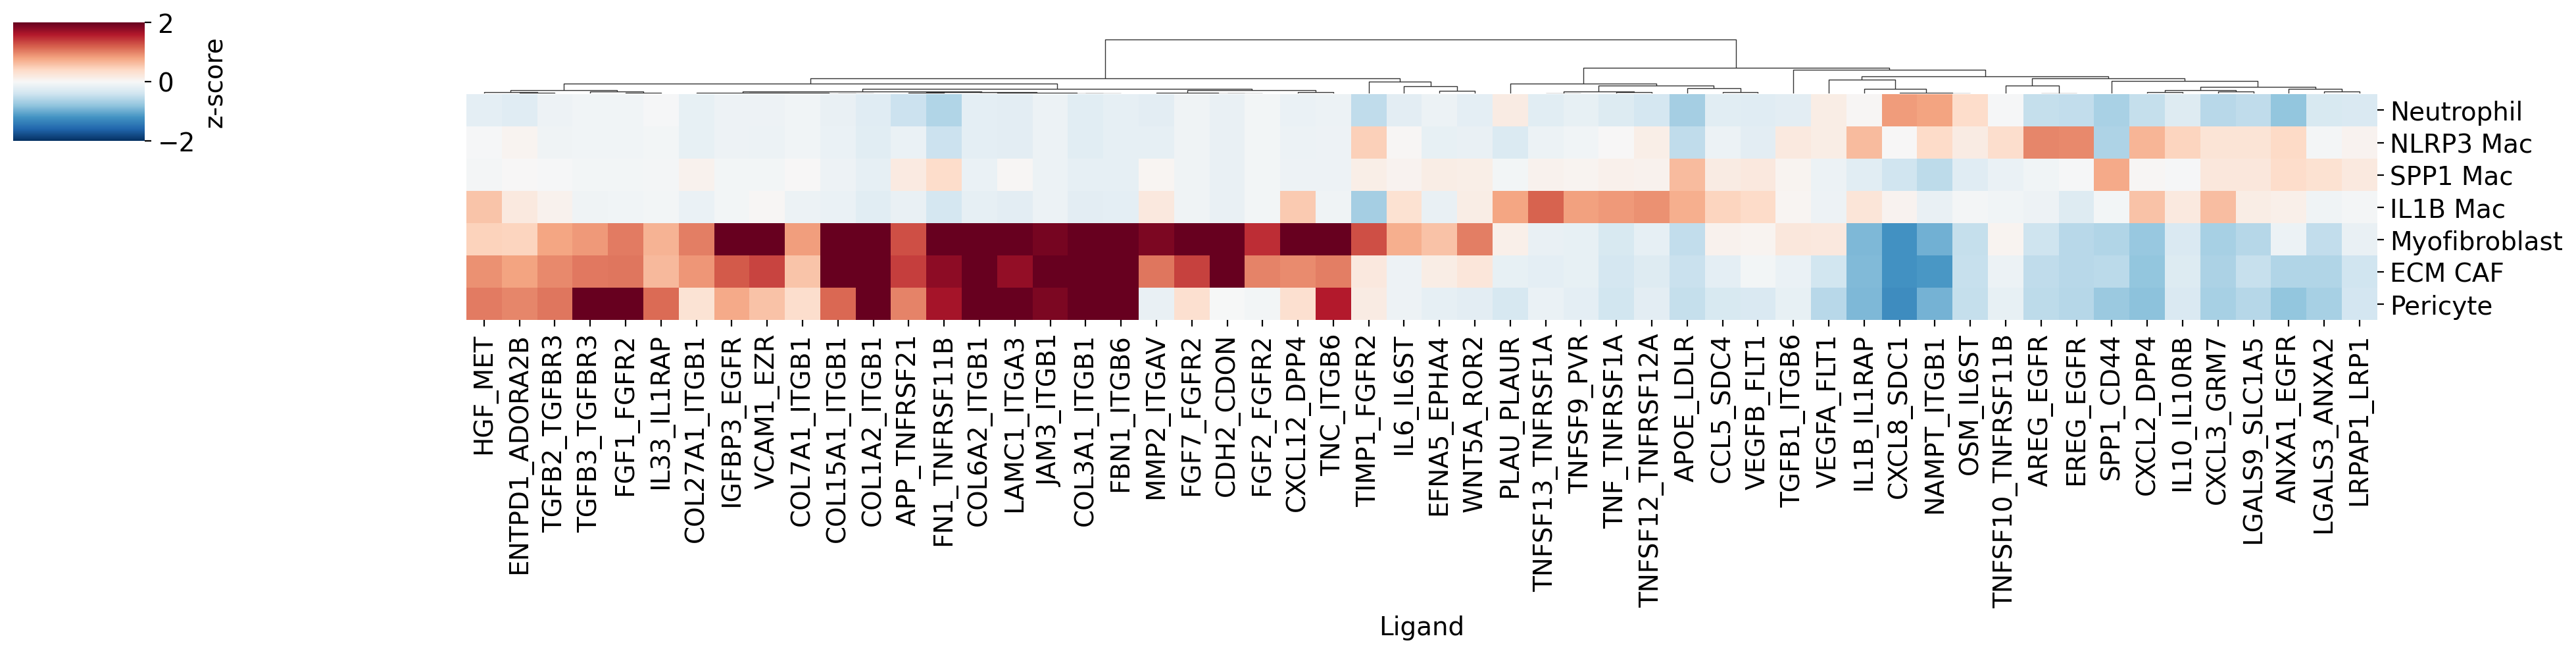

In [49]:
import matplotlib.pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
row_linkage, col_linkage = (hc.linkage(sp.distance.pdist(x, metric="cosine"), method="average")
  for x in (lr_df_one_receptor[senders].values.T, lr_df_one_receptor[senders].values))

import seaborn as sns

g = sns.clustermap(lr_df_one_receptor[senders].T, row_linkage=None, col_linkage=col_linkage, vmin=-2,vmax=2, figsize=(20,5),
                 cmap="RdBu_r", linecolor='black', cbar_kws={'label': 'z-score'})
#g.ax_cbar.set_position((0.15, 0.85, .03, .1))
g.ax_heatmap.set_xlabel("Ligand")
g.ax_row_dendrogram.set_visible(False)
plt.savefig(FIG2SAVE.joinpath(f'{gene_sign}_{receiver}_zscore_senders_ligands.pdf'), dpi=DPI,
            format="pdf", bbox_inches="tight",)

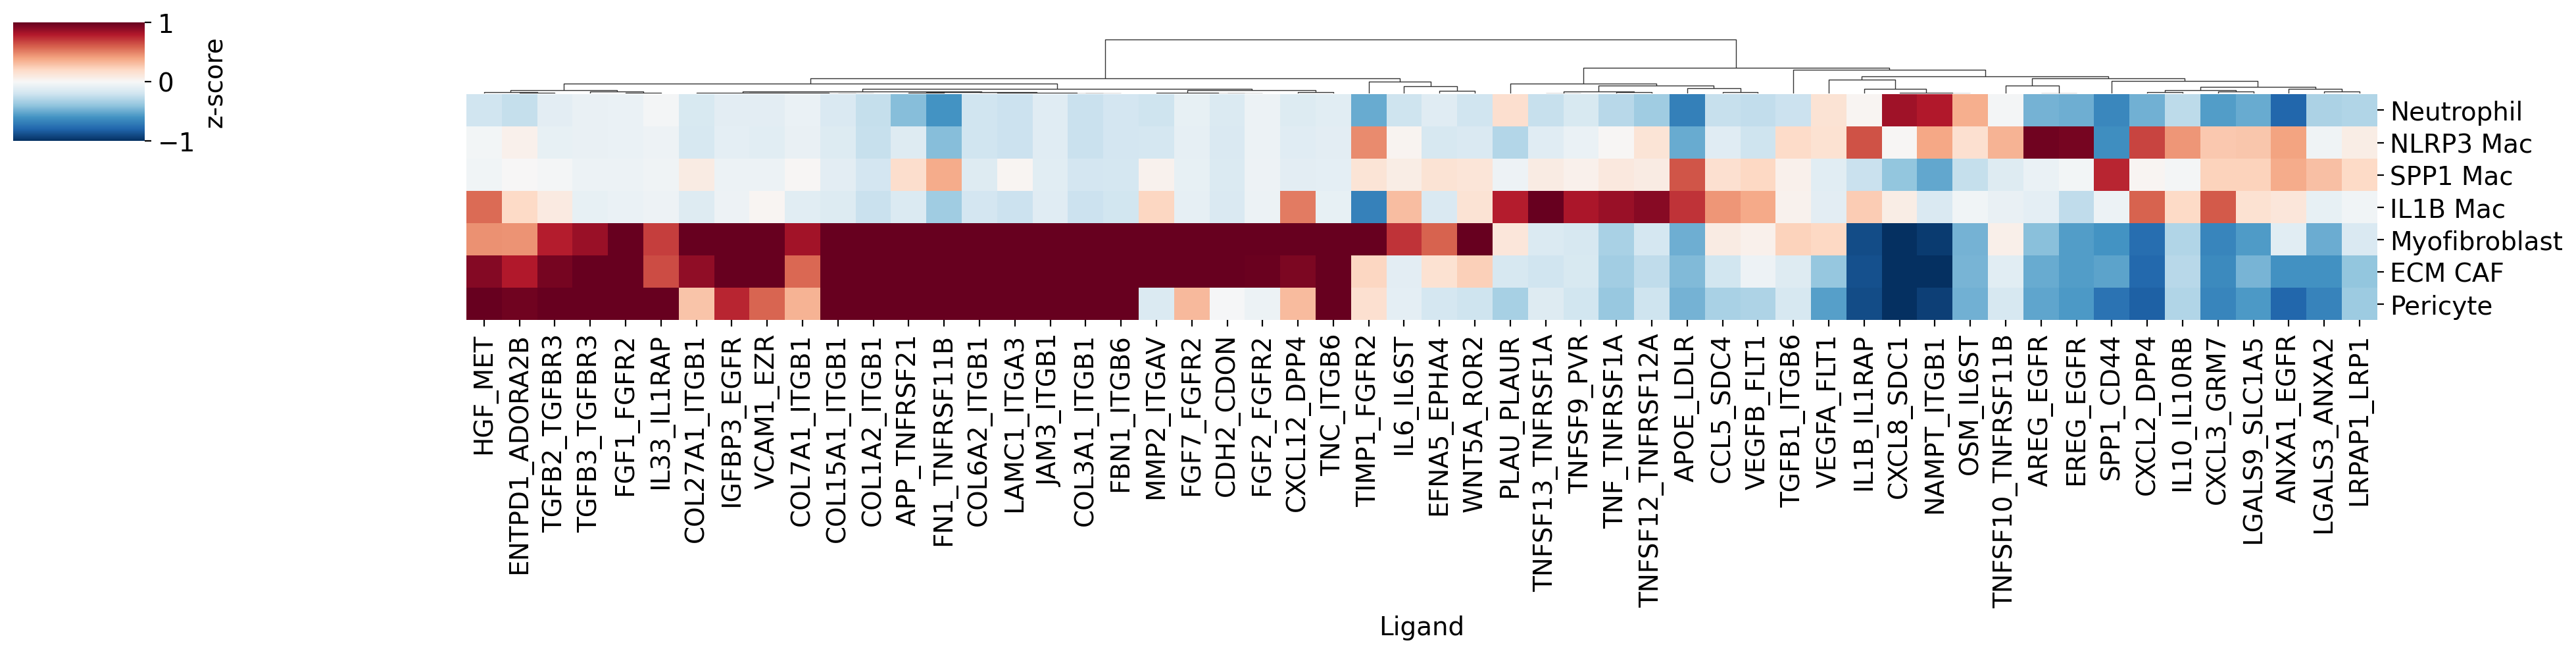

In [50]:
import matplotlib.pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
row_linkage, col_linkage = (hc.linkage(sp.distance.pdist(x, metric="cosine"), method="average")
  for x in (lr_df_one_receptor[senders].values.T, lr_df_one_receptor[senders].values))

import seaborn as sns

g = sns.clustermap(lr_df_one_receptor[senders].T, row_linkage=None, col_linkage=col_linkage, vmin=-1,vmax=1, figsize=(20,5),
                 cmap="RdBu_r", linecolor='black', cbar_kws={'label': 'z-score'})
#g.ax_cbar.set_position((0.15, 0.85, .03, .1))
g.ax_heatmap.set_xlabel("Ligand")
g.ax_row_dendrogram.set_visible(False)
plt.savefig(FIG2SAVE.joinpath(f'{gene_sign}_{receiver}_zscore_senders_ligands_vmaxvmin1.pdf'), dpi=DPI,
            format="pdf", bbox_inches="tight",)

In [51]:
# get order of ligands from the clustering
order_ligands = g.dendrogram_col.reordered_ind

In [52]:
# get order of celltypes of tme
order_tme = lr_df_one_receptor[senders].columns[g.dendrogram_row.reordered_ind].values

#### plot unique receptor ligand interaction for cancer states, 1 receptor

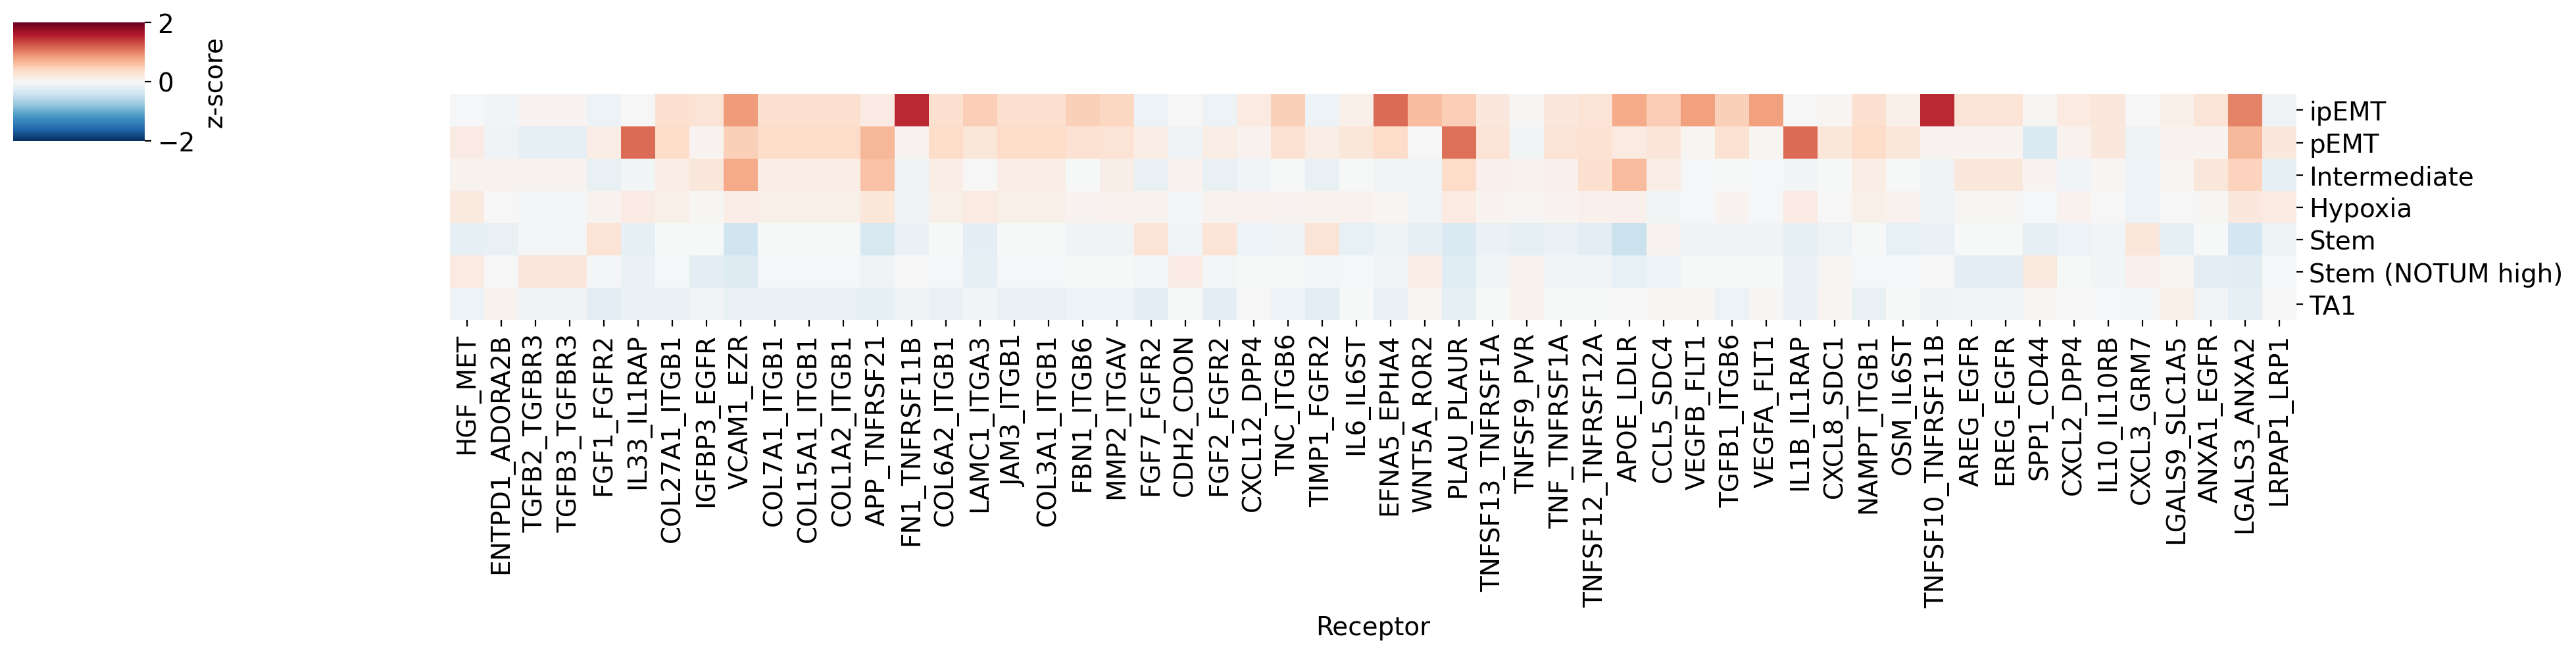

In [53]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
row_linkage_epi, col_linkage_epi = (hc.linkage(sp.distance.pdist(x, metric="euclidean"), method="average")
  for x in (lr_df_one_receptor[cancerstates2plot].values.T, lr_df_one_receptor[cancerstates2plot].values))

import seaborn as sns

g = sns.clustermap(lr_df_one_receptor[cancerstates2plot].T, row_linkage=row_linkage_epi, col_linkage=col_linkage, vmin=-2,vmax=2,
                 figsize=(20,5),
                 cmap="RdBu_r", linecolor='black', cbar_kws={'label': 'z-score'})
g.ax_heatmap.set_xlabel("Receptor")
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.savefig(FIG2SAVE.joinpath(f'{gene_sign}_{receiver}_zscore_receptors.pdf'), dpi=DPI,
            format="pdf", bbox_inches="tight",)
#g.ax_cbar.set_position((0.15, 0.85, .03, .1))

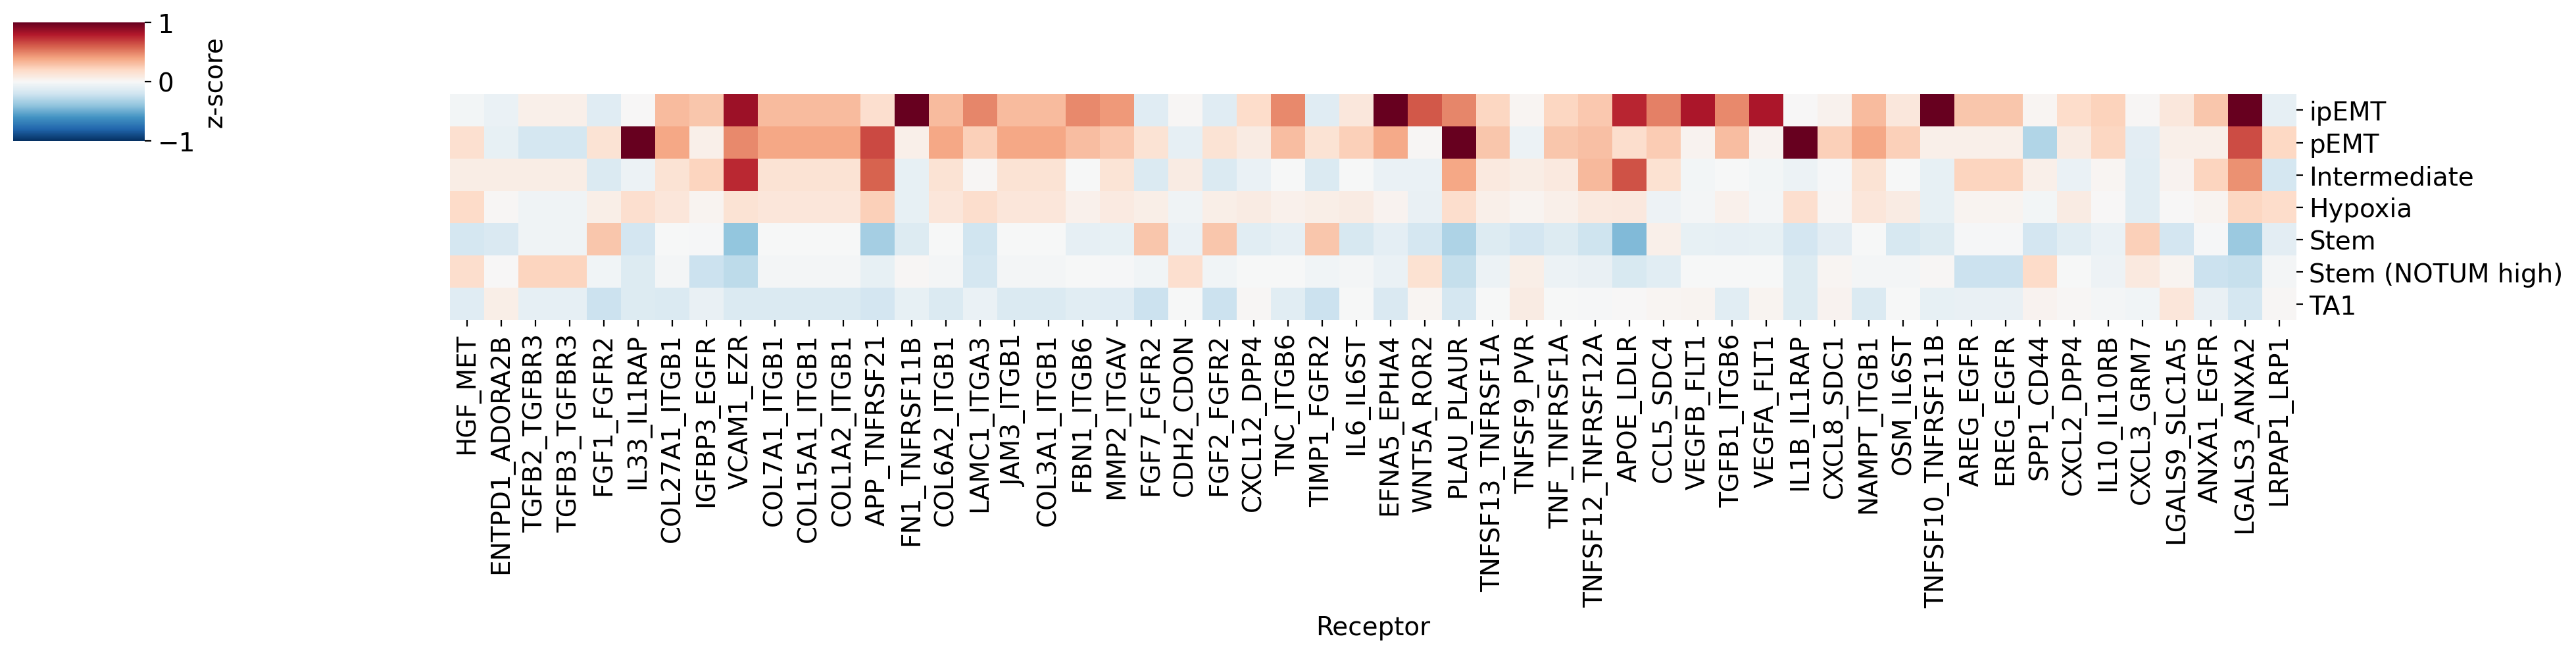

In [54]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
row_linkage_epi, col_linkage_epi = (hc.linkage(sp.distance.pdist(x, metric="euclidean"), method="average")
  for x in (lr_df_one_receptor[cancerstates2plot].values.T, lr_df_one_receptor[cancerstates2plot].values))

import seaborn as sns

g = sns.clustermap(lr_df_one_receptor[cancerstates2plot].T, row_linkage=row_linkage_epi, col_linkage=col_linkage, vmin=-1,vmax=1,
                 figsize=(20,5),
                 cmap="RdBu_r", linecolor='black', cbar_kws={'label': 'z-score'})
g.ax_heatmap.set_xlabel("Receptor")
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.savefig(FIG2SAVE.joinpath(f'{gene_sign}_{receiver}_zscore_receptors_vmaxvmin1.pdf'), dpi=DPI,
            format="pdf", bbox_inches="tight",)
#g.ax_cbar.set_position((0.15, 0.85, .03, .1))

In [55]:
# get order of celltypes of tme
order_receiver = lr_df_one_receptor[cancerstates2plot].columns[g.dendrogram_row.reordered_ind].values

### Plot ligand - gene target links heatmap

* sort ligand target df by order from clustermap of ligands above

In [56]:
n_ligands = len(lr_df["from"].unique())
vis_ligand_target = pd.read_csv(DIR2LOAD.joinpath(f"{gene_sign}{receiver}_nligands{n_ligands}_vis_ligand_target.csv"),
                                sep=",",
                                header=0,
                                index_col=0
                               )

In [57]:
# sort ligand target df by order from clustermap of ligands above
vis_ligand_target = vis_ligand_target.loc[lr_df_one_receptor.iloc[order_ligands,:]["from"],:].copy()

#### filter out some target genes by sum of potential

In [58]:
vis_ligand_target.loc[:, ["EMP1", "LAMC2", "FOS", "KRT18", "PLAU", "PLAUR", "FOSB"]].sum(axis=0)

EMP1     0.998763
LAMC2    1.304833
FOS      2.698889
KRT18    0.905871
PLAU     2.646910
PLAUR    1.910332
FOSB     0.876703
dtype: float64

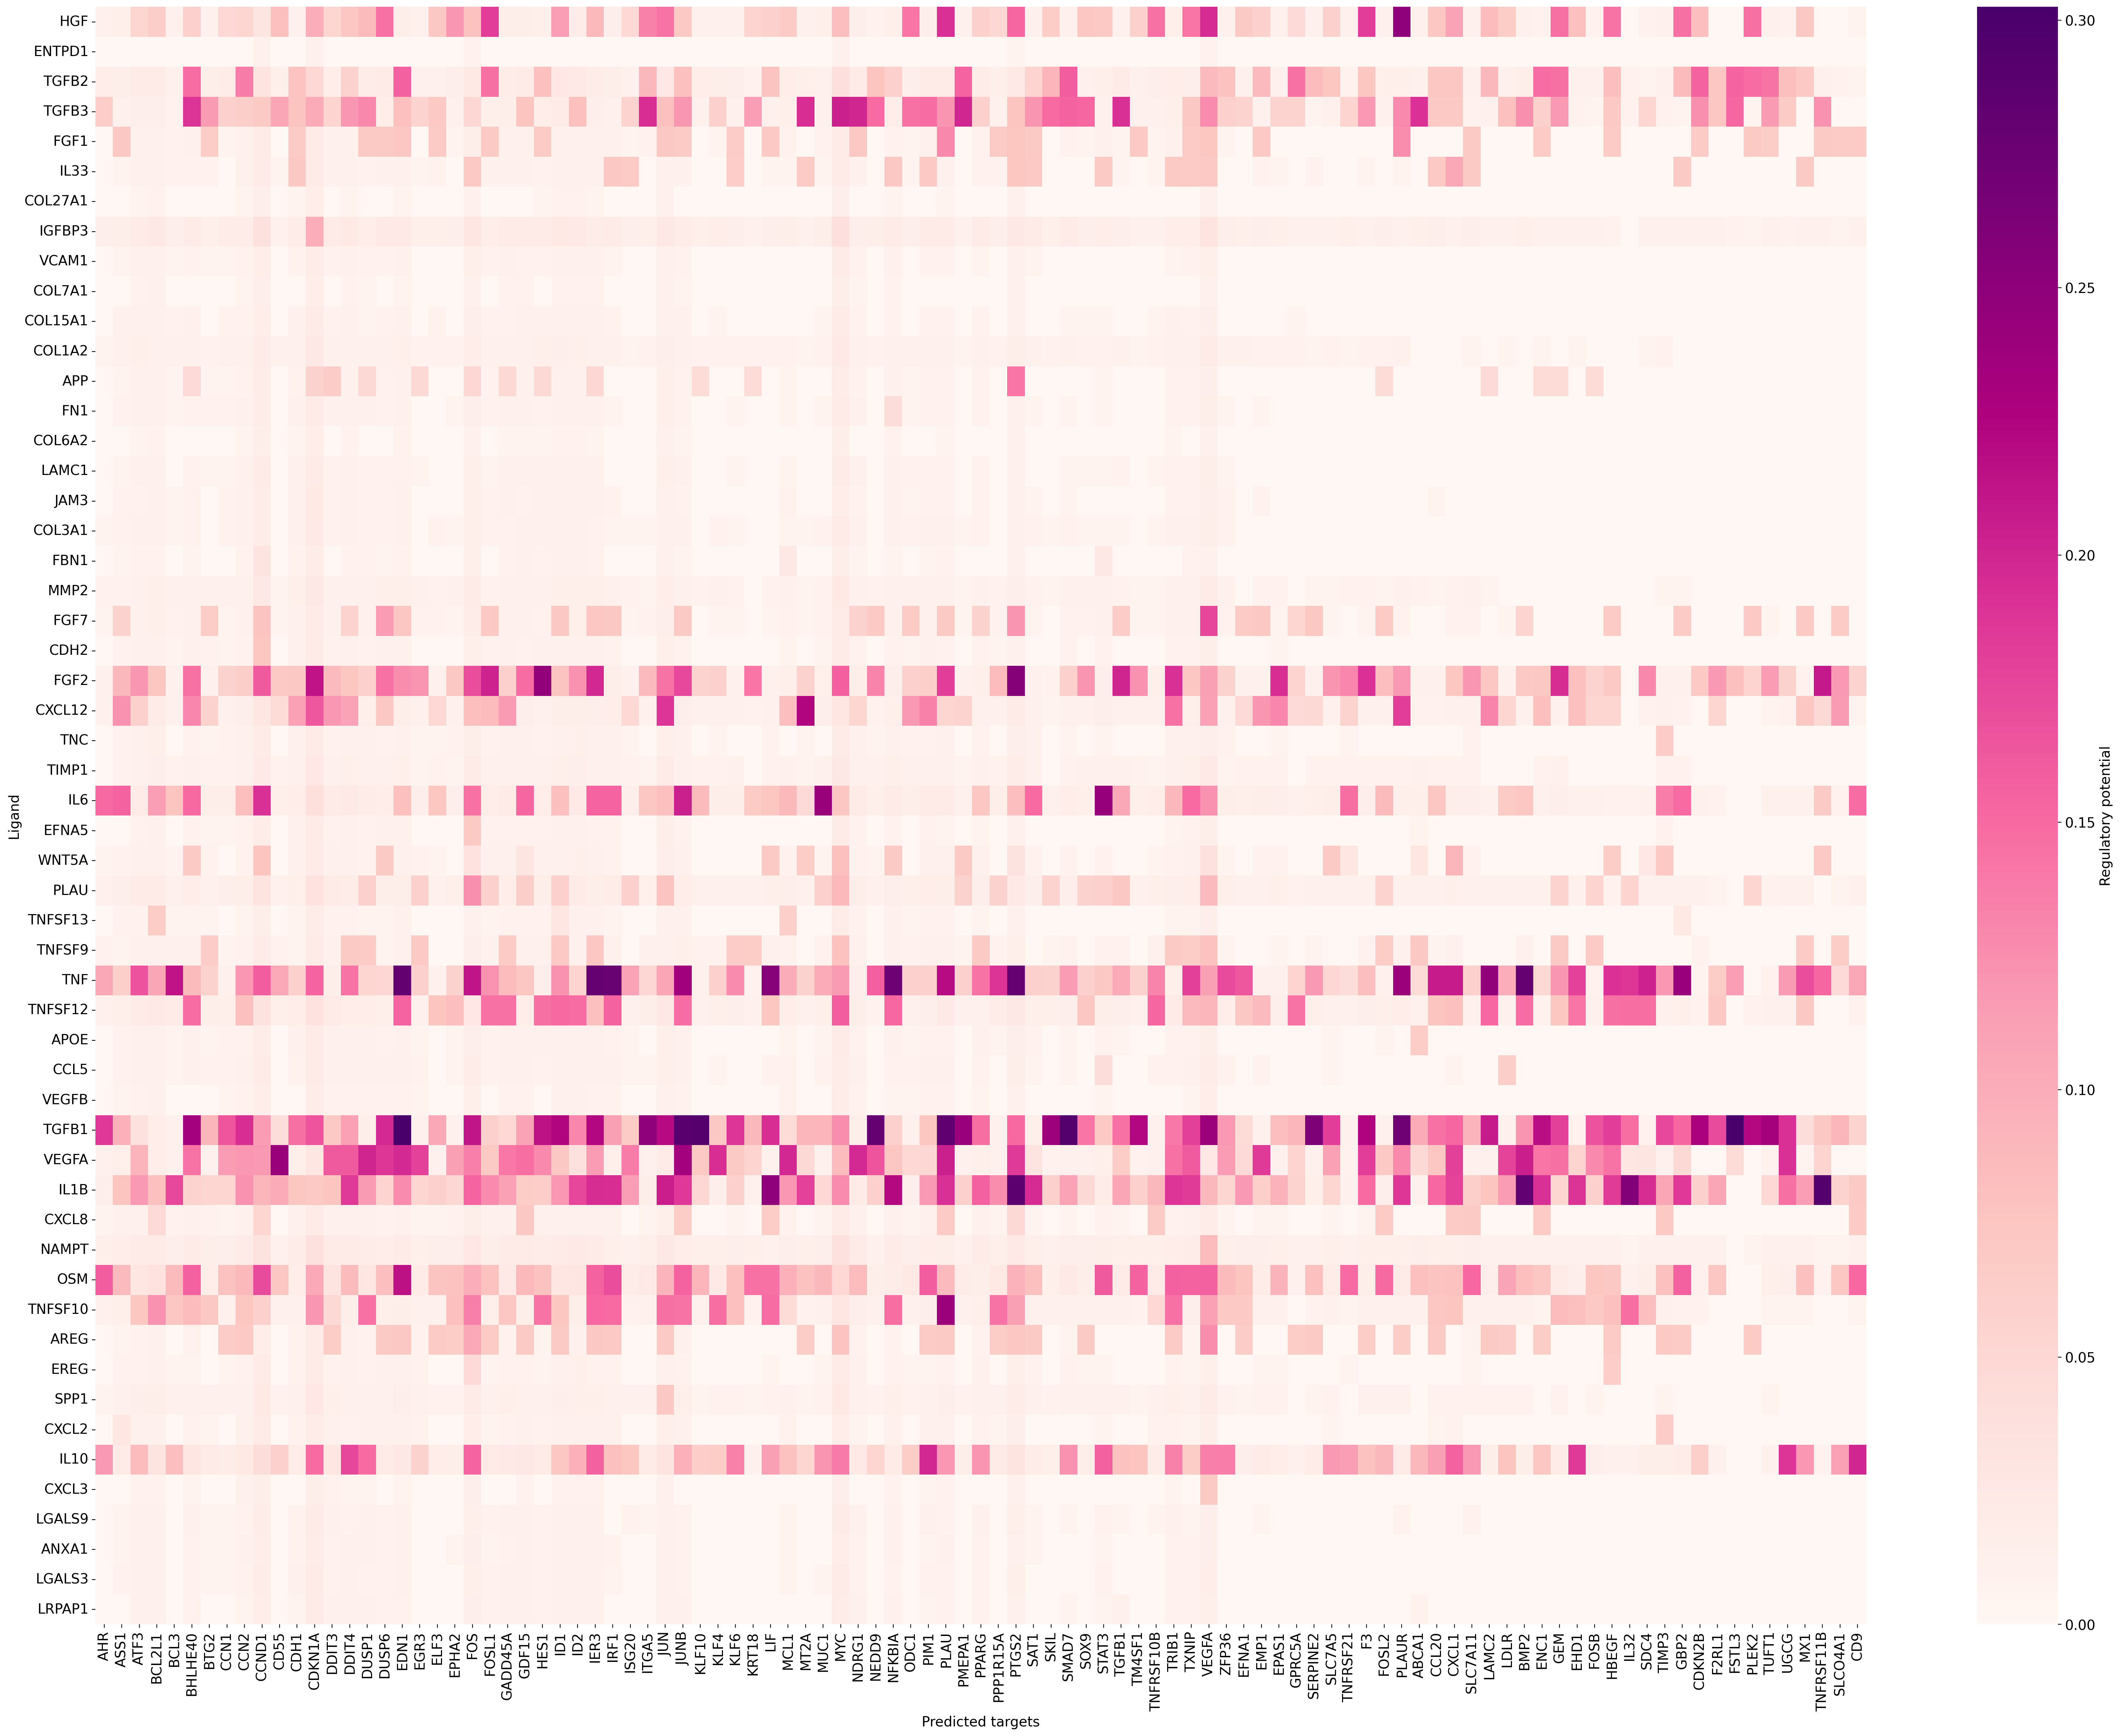

In [59]:
# set threshold TODO
threshold = 0.85
l_t_network2plot = vis_ligand_target.loc[:, vis_ligand_target.sum(axis=0)>threshold].copy()

plt.figure(figsize = (40,30))
ax = sns.heatmap(l_t_network2plot, cmap="RdPu", vmin=0,
            cbar_kws={'label': 'Regulatory potential'},
           )
ax.set_xlabel("Predicted targets")
ax.set_ylabel("Ligand")
plt.savefig(FIG2SAVE.joinpath(f'{gene_sign}_{receiver}_ligand_target_regulatory_network.pdf'), dpi=DPI,
            format="pdf", bbox_inches="tight",)

### plot ligand expression across sender cells

In [60]:
# get order of ligands from clustering ligands 
ligands2plot = lr_df_one_receptor.iloc[order_ligands,:]["from"]

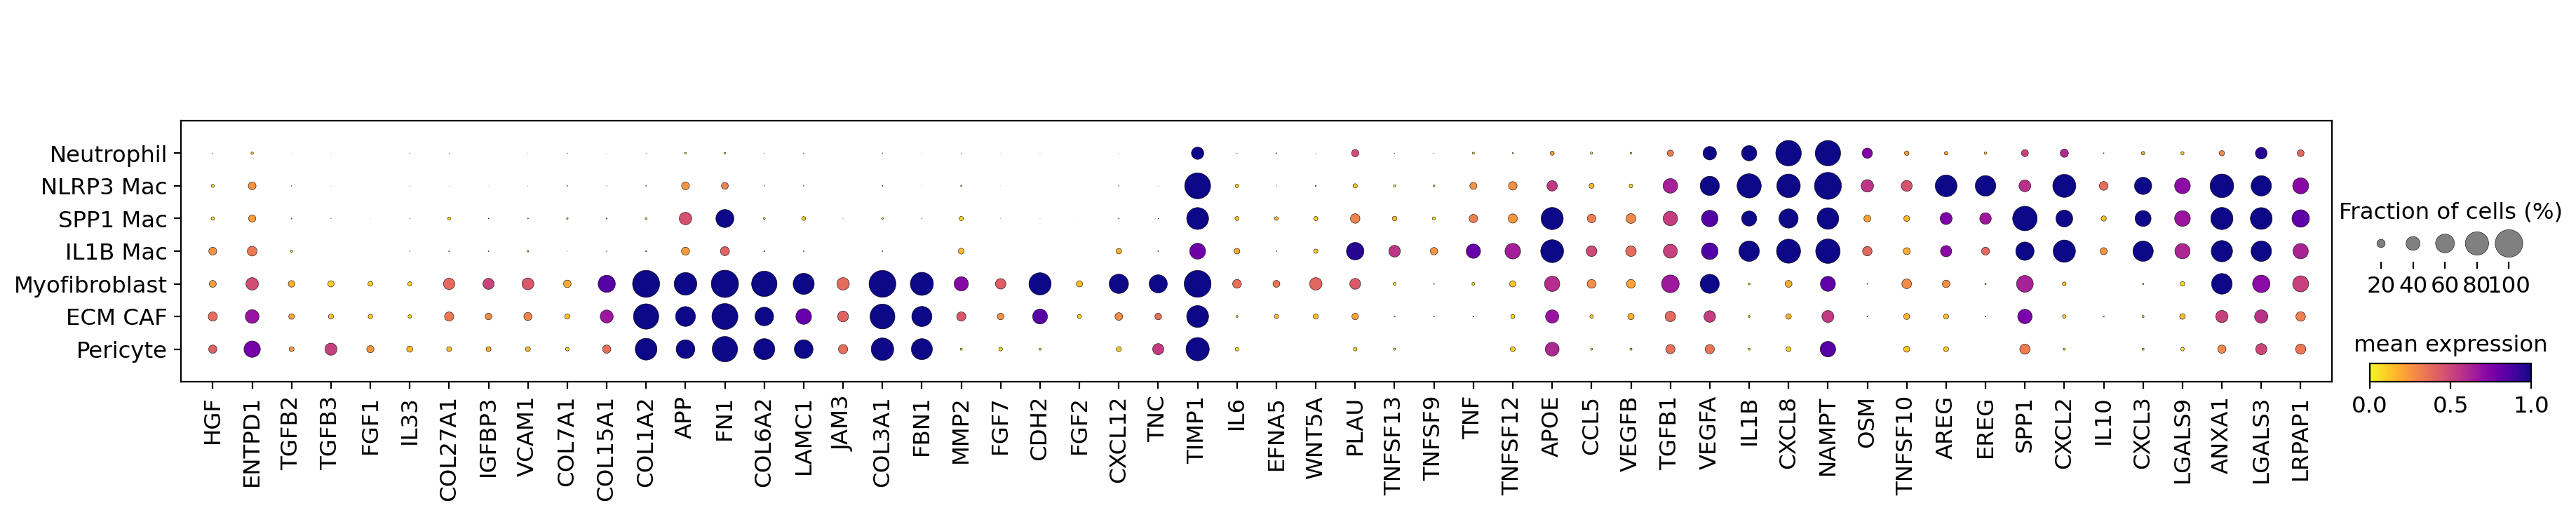

In [61]:
sc.pl.dotplot(adata=adata_sender, 
              var_names=ligands2plot,
              groupby="Annotation_scVI_detailed",
              categories_order=order_tme,
              cmap="plasma_r", #"coolwarm", 
              #layer="scaled", 
              vmin=0,
              vmax=1, 
              #standard_scale="var",
              #dot_max=0.5, 
              colorbar_title = "mean expression", 
              size_title="Fraction of cells (%)",
              #save=f'{gene_sign}_{receiver}_zscore_senders_ligands_pre-filtering.pdf'
             )

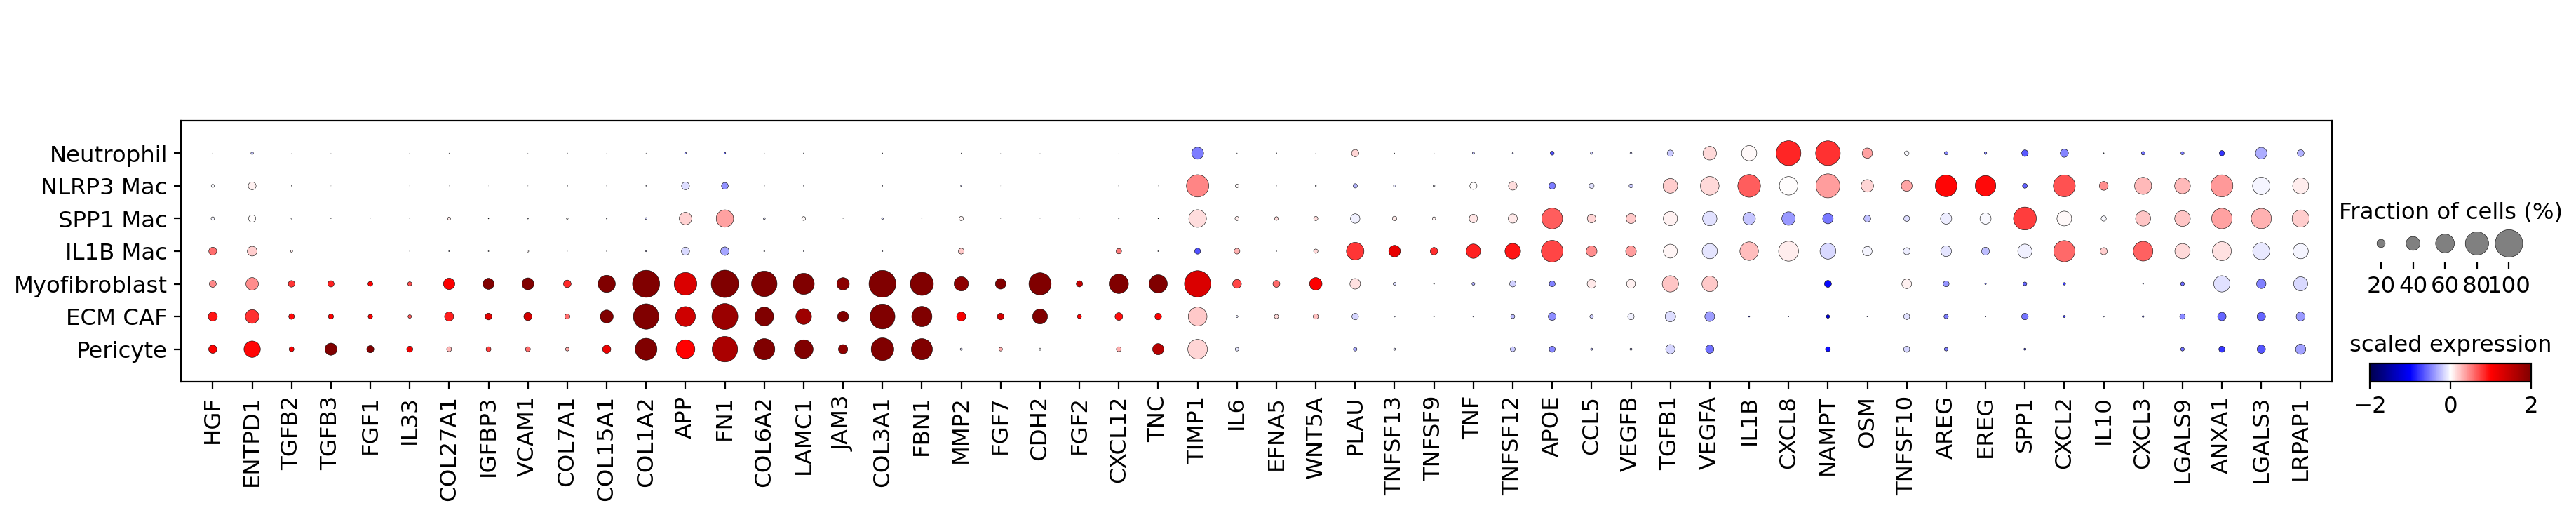

In [62]:
sc.pl.dotplot(adata=adata_zscore_sender, 
              var_names=ligands2plot,
              groupby="Annotation_scVI_detailed",
              categories_order=order_tme, #senders,
              cmap="seismic", #"coolwarm", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              #dot_max=0.5, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save=f'{gene_sign}_{receiver}_zscore_senders_ligands.pdf'
             )

**Ligands we could consider:**

From CAFs and myofibroblasts: 
"EFNA5", "ENTPD1", "FBN1", "FGF1", "FGF2", "FGF7", "FN1", "HGF", "IGFBP3", "IL33", "IL6", "IL7", "VEGFA", "APP", "LAMC1", "MMP2", "CXCL12", "TGFB1", "TGFB2", "TGFB3", "CDH2", "TIMP1","VCAM1", 
"JAM3", "TNC", "COL3A1", "COL6A2", "COL1A2", "COL27A1", "COL7A1", "COL15A1", "COPA", "WNT2", "WNT5A"

From macrophages:
"ANXA1", "APOE", "AREG", "CCL5", "CXCL3", "CXCL2", "CXCL8", "EREG", "IL10", "IL1B", 
"TNF", "TNFSF12", "TNFSF13", "TNFSF9", "TNFSF10", "VEGFB",
"LGALS9", "LGALS3", "LRPAP1",
"NAMPT", "OSM", "PLAU", "SPP1"

LRPAP1, APP, TIMP1 hallmark of angiogenesis https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10057494/

From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6972713/ :
- Besides, CAFs can directly interact with cancer cells via heterotypic E-cadherin–N-cadherin (CDH1–CDH2) adhesion and drive their invasion2 
- Indeed, CAFs are able to secrete factors, such as TGFβ and CXCL12, that directly stimulate cancer cell proliferation, EMT and migration
- Moreover, CAFs indirectly promote tumor spread via angiogenesis induction through VEGF and IL6s

CDH2: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5831988/

COPA: https://www.ed.ac.uk/institute-genetics-cancer/news-and-events/news-2020/copa-protein-linked-to-type-i-interferon-induction COPA protein linked to type I interferon induction and STING protein (stimulator of IFN genes)

JAM3: https://pubmed.ncbi.nlm.nih.gov/34839457/ 
Similarly, JAM3 (JAM-C), a junctional adhesion molecule, functions in endothelial cell adherence and has been shown to play imperative roles in melanoma lung metastases [42] and ovarian tumor development [43]; where genetic ablation of the target led to reduced metastasis and slowed tumor growth, respectively.  https://www.oncotarget.com/article/21915/text/

ENTPD1: https://www.mdpi.com/2072-6694/15/7/2014 https://www.tandfonline.com/doi/full/10.1080/2162402X.2021.1950953

---

### plot receptor expression across cancer cells

In [63]:
# get order of receptors from clustering ligands 
receptors2plot = lr_df_one_receptor.iloc[order_ligands,:]["to"]

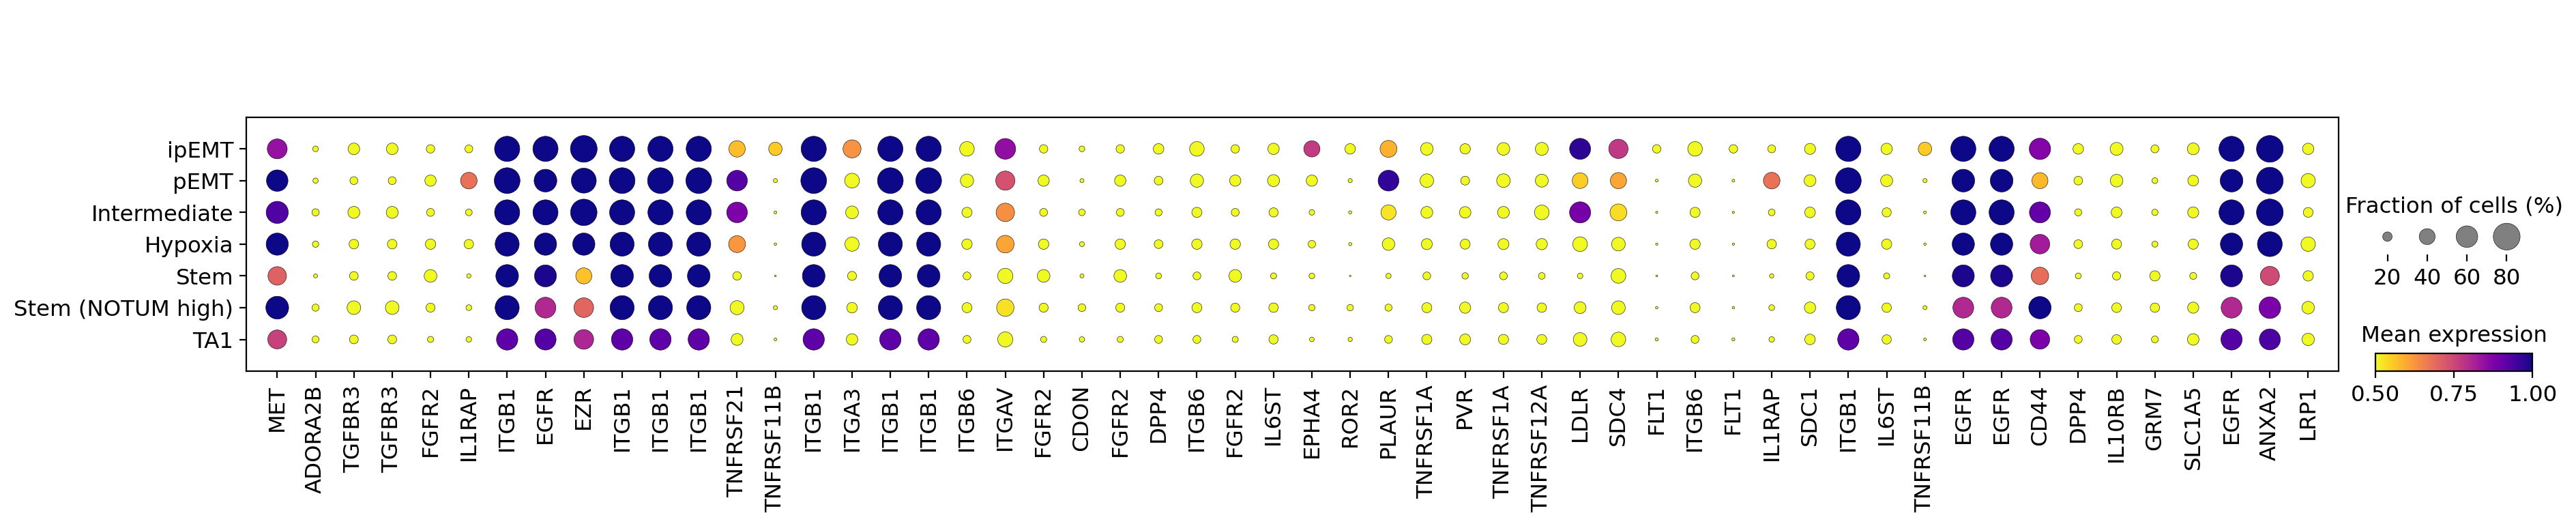

In [66]:
sc.pl.dotplot(adata=adata_zscore_epi, 
              var_names=receptors2plot,
              groupby="Annotation_scVI_detailed",
              categories_order=order_receiver,#cancerstates2plot,
              cmap="plasma_r", 
              #layer="scaled", 
              vmin=0.5,
              vmax=1, 
              dot_max=0.8, 
              colorbar_title = "Mean expression", 
              size_title="Fraction of cells (%)",
              #save=f'{gene_sign}_{receiver}_zscore_cancercells_receptors_pre-filtering.pdf'
             )

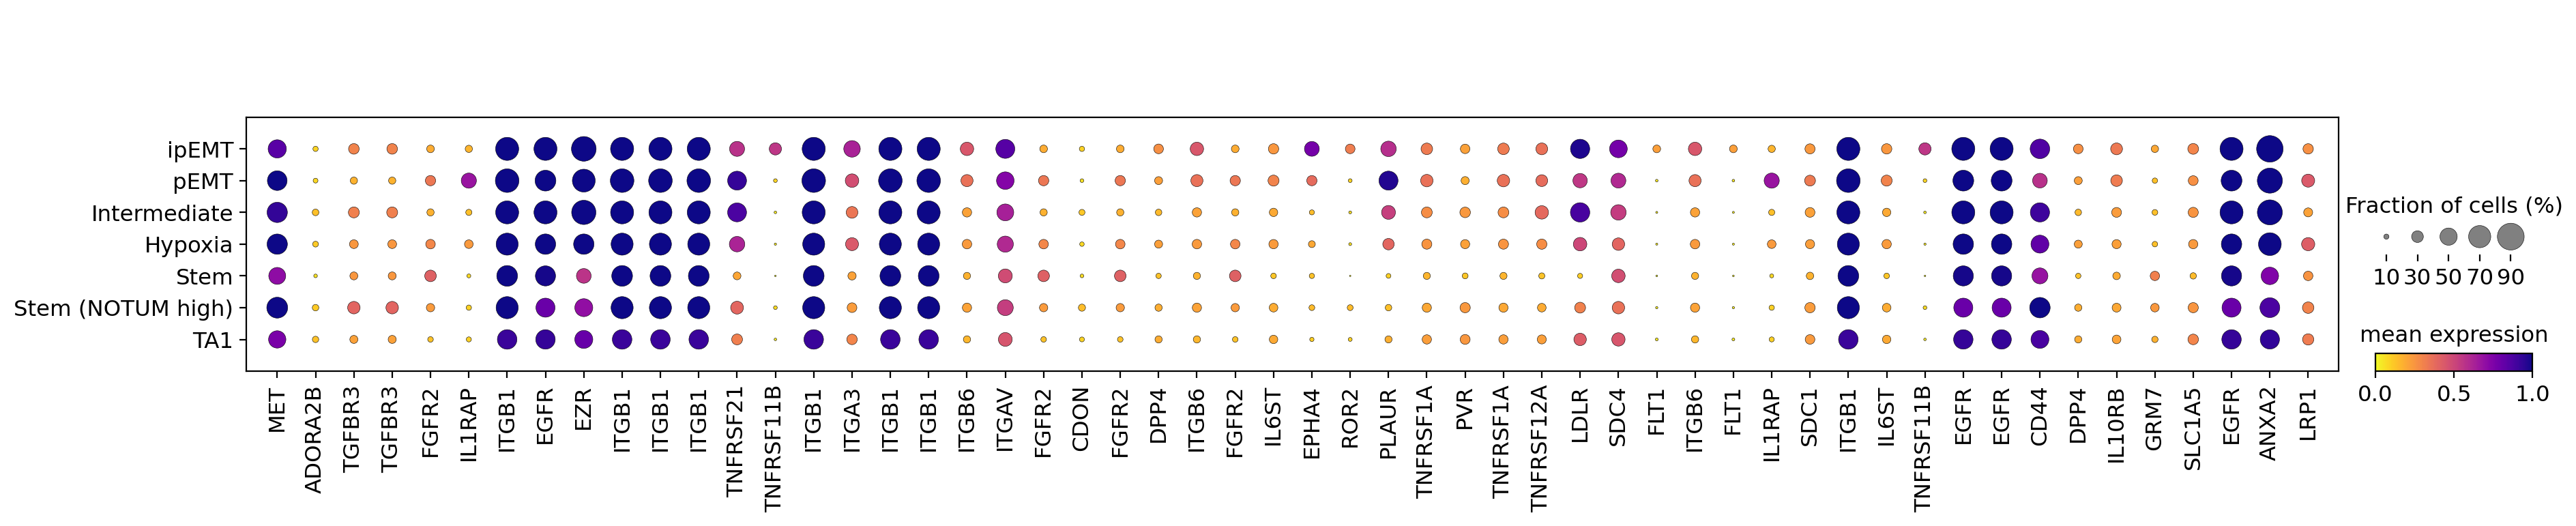

In [65]:
sc.pl.dotplot(adata=adata_epi[adata_epi.obs.Annotation_scVI_detailed.isin([
                  "Stem",
                  "Stem (NOTUM high)",
                  "TA1",
                  "Intermediate", 
                  "Hypoxia",
                  "pEMT",
                  "ipEMT"])], 
              var_names=receptors2plot,
              groupby="Annotation_scVI_detailed",
              categories_order=order_receiver,
              cmap="plasma_r", 
              layer="log1p", 
              vmin=0,
              vmax=1, 
              #standard_scale="var",
              #dot_max=0.5, 
              colorbar_title = "mean expression", 
              size_title="Fraction of cells (%)",
              #save=f'{gene_sign}_{receiver}_zscore_cancercells_receptors_pre-filtering.pdf'
             )

### if we plot all receptors (removing duplicates)

In [ ]:
# get order of receptors from clustering ligands 
receptors_all = lr_df["to"].drop_duplicates()

In [ ]:
sc.pl.dotplot(adata=adata_zscore_epi, 
              var_names=receptors_all,
              groupby="Annotation_scVI_detailed",
              categories_order=order_receiver,
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              #dot_max=0.5, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save=f'{gene_sign}_{receiver}_zscore_cancercells_all_receptors_pre-filtering.pdf'
             )